Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Augmented Dorsal Vein/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 5516 files belonging to 138 classes.
Using 4413 files for training.
Using 1103 files for validation.


In [4]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [5]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 3520 (110 batches of 32)
Total number of samples in validation_dataset: 1120 (35 batches of 32)
Total number of samples in test_dataset: 864 (27 batches of 32)


Prefetching data into GPU memory to optimize training process

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

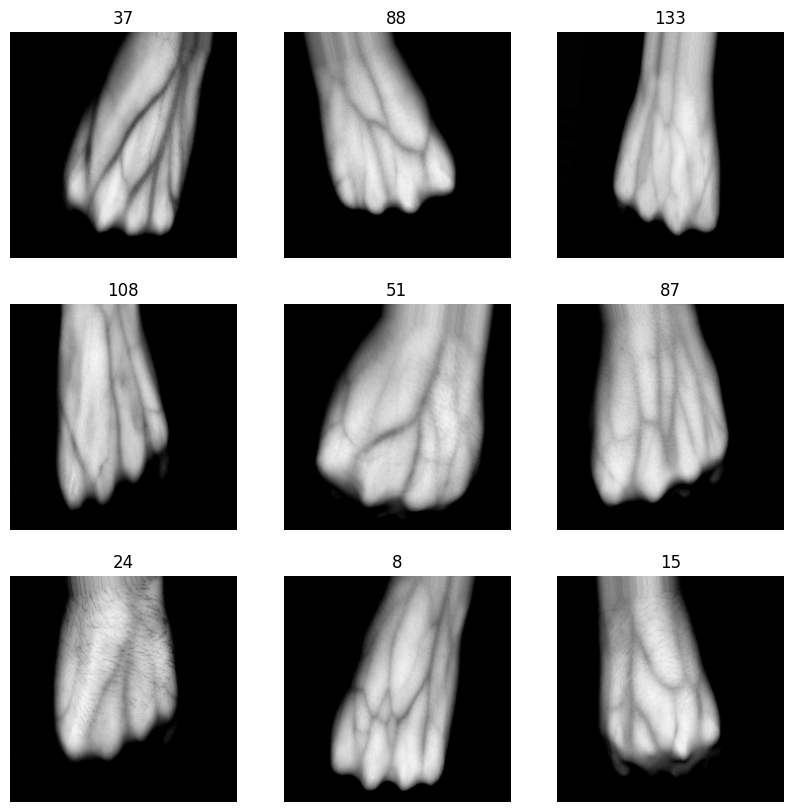

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Define some key constants

In [8]:
num_classes = 138
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [9]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [10]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [11]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [12]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": (make_alexnet_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG16": (make_vgg16_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG19": (make_vgg19_model(input_shape=image_size, num_classes=num_classes), 1e-4),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model[0].compile(
        optimizer=keras.optimizers.Adam(model[1]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model[0].fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
            reduce_lr
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 4.9534 - accuracy: 0.0119

  3%|▎         | 1/30 [00:07<03:42,  7.69s/it]

110/110 [==============================] - 8s 41ms/step - loss: 4.9534 - accuracy: 0.0119 - val_loss: 4.8938 - val_accuracy: 0.0091 - lr: 1.0000e-04
Epoch 2/30
109/110 [============================>.] - ETA: 0s - loss: 4.6957 - accuracy: 0.0338

  7%|▋         | 2/30 [00:12<02:46,  5.95s/it]

110/110 [==============================] - 5s 41ms/step - loss: 4.6928 - accuracy: 0.0349 - val_loss: 4.4549 - val_accuracy: 0.0571 - lr: 1.0000e-04
Epoch 3/30
109/110 [============================>.] - ETA: 0s - loss: 4.0643 - accuracy: 0.0912

 10%|█         | 3/30 [00:16<02:22,  5.26s/it]

110/110 [==============================] - 4s 38ms/step - loss: 4.0609 - accuracy: 0.0912 - val_loss: 3.6264 - val_accuracy: 0.1396 - lr: 1.0000e-04
Epoch 4/30
109/110 [============================>.] - ETA: 0s - loss: 3.2330 - accuracy: 0.2087

 13%|█▎        | 4/30 [00:21<02:07,  4.91s/it]

110/110 [==============================] - 4s 38ms/step - loss: 3.2291 - accuracy: 0.2094 - val_loss: 2.7468 - val_accuracy: 0.2838 - lr: 1.0000e-04
Epoch 5/30
109/110 [============================>.] - ETA: 0s - loss: 2.3057 - accuracy: 0.3882

 17%|█▋        | 5/30 [00:25<01:58,  4.73s/it]

110/110 [==============================] - 4s 38ms/step - loss: 2.3081 - accuracy: 0.3872 - val_loss: 1.8491 - val_accuracy: 0.5141 - lr: 1.0000e-04
Epoch 6/30
109/110 [============================>.] - ETA: 0s - loss: 1.5877 - accuracy: 0.5576

 20%|██        | 6/30 [00:29<01:50,  4.60s/it]

110/110 [==============================] - 4s 38ms/step - loss: 1.5874 - accuracy: 0.5574 - val_loss: 1.3490 - val_accuracy: 0.6156 - lr: 1.0000e-04
Epoch 7/30
109/110 [============================>.] - ETA: 0s - loss: 1.0759 - accuracy: 0.6872

 23%|██▎       | 7/30 [00:34<01:44,  4.53s/it]

110/110 [==============================] - 4s 38ms/step - loss: 1.0774 - accuracy: 0.6878 - val_loss: 0.8324 - val_accuracy: 0.7634 - lr: 1.0000e-04
Epoch 8/30
109/110 [============================>.] - ETA: 0s - loss: 0.6964 - accuracy: 0.7939

 27%|██▋       | 8/30 [00:38<01:38,  4.47s/it]


Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 4s 38ms/step - loss: 0.6976 - accuracy: 0.7935 - val_loss: 0.9147 - val_accuracy: 0.7353 - lr: 1.0000e-04
Epoch 9/30
109/110 [============================>.] - ETA: 0s - loss: 0.4055 - accuracy: 0.8856

 30%|███       | 9/30 [00:43<01:32,  4.42s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.4086 - accuracy: 0.8852 - val_loss: 0.4177 - val_accuracy: 0.8821 - lr: 5.0000e-05
Epoch 10/30
109/110 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.9206

 33%|███▎      | 10/30 [00:47<01:27,  4.39s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.2942 - accuracy: 0.9190 - val_loss: 0.3711 - val_accuracy: 0.8930 - lr: 5.0000e-05
Epoch 11/30
109/110 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9386

 37%|███▋      | 11/30 [00:51<01:23,  4.38s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.2094 - accuracy: 0.9386 - val_loss: 0.3040 - val_accuracy: 0.9121 - lr: 5.0000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9477

 40%|████      | 12/30 [00:56<01:18,  4.39s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.1846 - accuracy: 0.9477 - val_loss: 0.2957 - val_accuracy: 0.9093 - lr: 5.0000e-05
Epoch 13/30
109/110 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9547

 43%|████▎     | 13/30 [01:00<01:14,  4.37s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.1547 - accuracy: 0.9534 - val_loss: 0.2877 - val_accuracy: 0.9121 - lr: 5.0000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9622

 47%|████▋     | 14/30 [01:04<01:09,  4.37s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.1306 - accuracy: 0.9622 - val_loss: 0.2312 - val_accuracy: 0.9320 - lr: 5.0000e-05
Epoch 15/30
109/110 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9682

 50%|█████     | 15/30 [01:09<01:05,  4.37s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.1187 - accuracy: 0.9682 - val_loss: 0.2085 - val_accuracy: 0.9347 - lr: 5.0000e-05
Epoch 16/30
109/110 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9745

 53%|█████▎    | 16/30 [01:13<01:01,  4.37s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0935 - accuracy: 0.9741 - val_loss: 0.1926 - val_accuracy: 0.9402 - lr: 5.0000e-05
Epoch 17/30
109/110 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9776

 57%|█████▋    | 17/30 [01:17<00:56,  4.37s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.0913 - accuracy: 0.9776 - val_loss: 0.1901 - val_accuracy: 0.9429 - lr: 5.0000e-05
Epoch 18/30
109/110 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9808

 60%|██████    | 18/30 [01:22<00:52,  4.35s/it]


Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 4s 37ms/step - loss: 0.0703 - accuracy: 0.9807 - val_loss: 0.2286 - val_accuracy: 0.9302 - lr: 5.0000e-05
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9835

 63%|██████▎   | 19/30 [01:26<00:48,  4.36s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0573 - accuracy: 0.9835 - val_loss: 0.1485 - val_accuracy: 0.9538 - lr: 2.5000e-05
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9920

 67%|██████▋   | 20/30 [01:30<00:43,  4.35s/it]


Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 4s 37ms/step - loss: 0.0374 - accuracy: 0.9920 - val_loss: 0.1494 - val_accuracy: 0.9556 - lr: 2.5000e-05
Epoch 21/30
109/110 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9917

 70%|███████   | 21/30 [01:35<00:39,  4.36s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0396 - accuracy: 0.9912 - val_loss: 0.1374 - val_accuracy: 0.9592 - lr: 1.2500e-05
Epoch 22/30
109/110 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9934

 73%|███████▎  | 22/30 [01:39<00:34,  4.34s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.0302 - accuracy: 0.9929 - val_loss: 0.1272 - val_accuracy: 0.9574 - lr: 1.2500e-05
Epoch 23/30
109/110 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9928

 77%|███████▋  | 23/30 [01:43<00:30,  4.34s/it]


Epoch 23: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 4s 38ms/step - loss: 0.0289 - accuracy: 0.9926 - val_loss: 0.1293 - val_accuracy: 0.9592 - lr: 1.2500e-05
Epoch 24/30
109/110 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9943

 80%|████████  | 24/30 [01:48<00:26,  4.33s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.0263 - accuracy: 0.9940 - val_loss: 0.1216 - val_accuracy: 0.9655 - lr: 6.2500e-06
Epoch 25/30
109/110 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9914

 83%|████████▎ | 25/30 [01:52<00:21,  4.34s/it]


Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 4s 38ms/step - loss: 0.0305 - accuracy: 0.9912 - val_loss: 0.1275 - val_accuracy: 0.9619 - lr: 6.2500e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9946

 87%|████████▋ | 26/30 [01:56<00:17,  4.34s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0256 - accuracy: 0.9946 - val_loss: 0.1204 - val_accuracy: 0.9628 - lr: 3.1250e-06
Epoch 27/30
109/110 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9960

 90%|█████████ | 27/30 [02:01<00:13,  4.34s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0250 - accuracy: 0.9949 - val_loss: 0.1192 - val_accuracy: 0.9619 - lr: 3.1250e-06
Epoch 28/30
109/110 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9948

 93%|█████████▎| 28/30 [02:05<00:08,  4.35s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0273 - accuracy: 0.9943 - val_loss: 0.1177 - val_accuracy: 0.9610 - lr: 3.1250e-06
Epoch 29/30
109/110 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9937

 97%|█████████▋| 29/30 [02:09<00:04,  4.34s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.0269 - accuracy: 0.9932 - val_loss: 0.1169 - val_accuracy: 0.9628 - lr: 3.1250e-06
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9943

100%|██████████| 30/30 [02:14<00:00,  4.34s/it]


Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 4s 38ms/step - loss: 0.0231 - accuracy: 0.9943 - val_loss: 0.1188 - val_accuracy: 0.9655 - lr: 3.1250e-06


100%|██████████| 30/30 [02:14<00:00,  4.48s/it]


Finished training AlexNet in 134.37s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 5.5803 - accuracy: 0.0153

  3%|▎         | 1/30 [00:33<16:10, 33.48s/it]

110/110 [==============================] - 33s 253ms/step - loss: 5.5803 - accuracy: 0.0153 - val_loss: 5.0161 - val_accuracy: 0.0054 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 4.4114 - accuracy: 0.0798

  7%|▋         | 2/30 [01:00<13:46, 29.50s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 27s 241ms/step - loss: 4.4114 - accuracy: 0.0798 - val_loss: 5.0980 - val_accuracy: 0.0172 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 3.4056 - accuracy: 0.1977

 10%|█         | 3/30 [01:26<12:42, 28.25s/it]

110/110 [==============================] - 27s 242ms/step - loss: 3.4056 - accuracy: 0.1977 - val_loss: 4.4724 - val_accuracy: 0.0843 - lr: 5.0000e-05
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 2.7961 - accuracy: 0.3043

 13%|█▎        | 4/30 [01:53<11:59, 27.66s/it]

110/110 [==============================] - 27s 242ms/step - loss: 2.7961 - accuracy: 0.3043 - val_loss: 3.4836 - val_accuracy: 0.1686 - lr: 5.0000e-05
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 2.1833 - accuracy: 0.4313

 17%|█▋        | 5/30 [02:20<11:23, 27.34s/it]

110/110 [==============================] - 27s 242ms/step - loss: 2.1833 - accuracy: 0.4313 - val_loss: 2.0410 - val_accuracy: 0.4714 - lr: 5.0000e-05
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.5577

 20%|██        | 6/30 [02:47<10:51, 27.15s/it]

110/110 [==============================] - 27s 242ms/step - loss: 1.6023 - accuracy: 0.5577 - val_loss: 1.9358 - val_accuracy: 0.4714 - lr: 5.0000e-05
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 1.1673 - accuracy: 0.6733

 23%|██▎       | 7/30 [03:14<10:21, 27.03s/it]

110/110 [==============================] - 27s 242ms/step - loss: 1.1673 - accuracy: 0.6733 - val_loss: 0.8276 - val_accuracy: 0.8187 - lr: 5.0000e-05
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7713

 27%|██▋       | 8/30 [03:40<09:52, 26.94s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.8133 - accuracy: 0.7713 - val_loss: 0.7621 - val_accuracy: 0.8123 - lr: 5.0000e-05
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.8219

 30%|███       | 9/30 [04:07<09:24, 26.88s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.6104 - accuracy: 0.8219 - val_loss: 0.4690 - val_accuracy: 0.8803 - lr: 5.0000e-05
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8903

 33%|███▎      | 10/30 [04:34<08:56, 26.85s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.3994 - accuracy: 0.8903 - val_loss: 0.3903 - val_accuracy: 0.9066 - lr: 5.0000e-05
Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9176

 37%|███▋      | 11/30 [05:01<08:29, 26.81s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.2962 - accuracy: 0.9176 - val_loss: 0.2677 - val_accuracy: 0.9266 - lr: 5.0000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9466

 40%|████      | 12/30 [05:27<08:02, 26.82s/it]


Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 27s 242ms/step - loss: 0.2102 - accuracy: 0.9466 - val_loss: 0.4059 - val_accuracy: 0.8858 - lr: 5.0000e-05
Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9648

 43%|████▎     | 13/30 [05:54<07:35, 26.80s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.1437 - accuracy: 0.9648 - val_loss: 0.1767 - val_accuracy: 0.9556 - lr: 2.5000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9696

 47%|████▋     | 14/30 [06:21<07:08, 26.80s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.1241 - accuracy: 0.9696 - val_loss: 0.1474 - val_accuracy: 0.9674 - lr: 2.5000e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9801

 50%|█████     | 15/30 [06:48<06:41, 26.79s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0903 - accuracy: 0.9801 - val_loss: 0.1278 - val_accuracy: 0.9692 - lr: 2.5000e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9798

 53%|█████▎    | 16/30 [07:15<06:15, 26.81s/it]


Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 27s 242ms/step - loss: 0.0902 - accuracy: 0.9798 - val_loss: 0.1912 - val_accuracy: 0.9456 - lr: 2.5000e-05
Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9830

 57%|█████▋    | 17/30 [07:41<05:48, 26.78s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0740 - accuracy: 0.9830 - val_loss: 0.1274 - val_accuracy: 0.9619 - lr: 1.2500e-05
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9852

 60%|██████    | 18/30 [08:08<05:21, 26.78s/it]


Epoch 18: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 27s 242ms/step - loss: 0.0676 - accuracy: 0.9852 - val_loss: 0.1274 - val_accuracy: 0.9646 - lr: 1.2500e-05
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9861

 63%|██████▎   | 19/30 [08:35<04:54, 26.78s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0578 - accuracy: 0.9861 - val_loss: 0.1060 - val_accuracy: 0.9719 - lr: 6.2500e-06
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9886

 67%|██████▋   | 20/30 [09:02<04:28, 26.81s/it]


Epoch 20: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 27s 243ms/step - loss: 0.0613 - accuracy: 0.9886 - val_loss: 0.1062 - val_accuracy: 0.9737 - lr: 6.2500e-06
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9901

 70%|███████   | 21/30 [09:28<04:01, 26.80s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0506 - accuracy: 0.9901 - val_loss: 0.1019 - val_accuracy: 0.9773 - lr: 3.1250e-06
Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9952

 73%|███████▎  | 22/30 [09:55<03:34, 26.79s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0454 - accuracy: 0.9952 - val_loss: 0.1012 - val_accuracy: 0.9746 - lr: 3.1250e-06
Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9920

 77%|███████▋  | 23/30 [10:22<03:07, 26.78s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0486 - accuracy: 0.9920 - val_loss: 0.1011 - val_accuracy: 0.9737 - lr: 3.1250e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9918

 80%|████████  | 24/30 [10:49<02:40, 26.78s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0430 - accuracy: 0.9918 - val_loss: 0.0988 - val_accuracy: 0.9737 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9943

 83%|████████▎ | 25/30 [11:16<02:13, 26.77s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0455 - accuracy: 0.9943 - val_loss: 0.0983 - val_accuracy: 0.9746 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9949

 87%|████████▋ | 26/30 [11:42<01:47, 26.78s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0386 - accuracy: 0.9949 - val_loss: 0.0958 - val_accuracy: 0.9737 - lr: 3.1250e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9935

 90%|█████████ | 27/30 [12:09<01:20, 26.79s/it]


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 27s 242ms/step - loss: 0.0396 - accuracy: 0.9935 - val_loss: 0.0964 - val_accuracy: 0.9737 - lr: 3.1250e-06
Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9929

 93%|█████████▎| 28/30 [12:36<00:53, 26.80s/it]

110/110 [==============================] - 27s 242ms/step - loss: 0.0457 - accuracy: 0.9929 - val_loss: 0.0952 - val_accuracy: 0.9728 - lr: 1.5625e-06
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9898

 97%|█████████▋| 29/30 [13:02<00:26, 26.67s/it]


Epoch 29: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
110/110 [==============================] - 26s 238ms/step - loss: 0.0454 - accuracy: 0.9898 - val_loss: 0.0964 - val_accuracy: 0.9728 - lr: 1.5625e-06
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9892

100%|██████████| 30/30 [13:28<00:00, 26.23s/it]


Epoch 30: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
110/110 [==============================] - 25s 228ms/step - loss: 0.0451 - accuracy: 0.9892 - val_loss: 0.0953 - val_accuracy: 0.9728 - lr: 7.8125e-07


100%|██████████| 30/30 [13:28<00:00, 26.93s/it]


Finished training VGG16 in 808.03s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 5.6871 - accuracy: 0.0145

  3%|▎         | 1/30 [00:29<14:21, 29.69s/it]

110/110 [==============================] - 30s 252ms/step - loss: 5.6871 - accuracy: 0.0145 - val_loss: 4.9730 - val_accuracy: 0.0054 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 4.7389 - accuracy: 0.0423

  7%|▋         | 2/30 [00:57<13:15, 28.40s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 27s 249ms/step - loss: 4.7389 - accuracy: 0.0423 - val_loss: 5.1495 - val_accuracy: 0.0109 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 4.0511 - accuracy: 0.1148

 10%|█         | 3/30 [01:24<12:35, 27.99s/it]


Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 28s 248ms/step - loss: 4.0511 - accuracy: 0.1148 - val_loss: 5.0202 - val_accuracy: 0.0236 - lr: 5.0000e-05
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 3.3941 - accuracy: 0.1855

 13%|█▎        | 4/30 [01:52<12:03, 27.81s/it]

110/110 [==============================] - 28s 249ms/step - loss: 3.3941 - accuracy: 0.1855 - val_loss: 4.0270 - val_accuracy: 0.0843 - lr: 2.5000e-05
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 3.0273 - accuracy: 0.2560

 17%|█▋        | 5/30 [02:20<11:40, 28.02s/it]

110/110 [==============================] - 28s 257ms/step - loss: 3.0273 - accuracy: 0.2560 - val_loss: 3.0769 - val_accuracy: 0.2375 - lr: 2.5000e-05
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 2.6947 - accuracy: 0.3116

 20%|██        | 6/30 [02:50<11:25, 28.55s/it]

110/110 [==============================] - 30s 267ms/step - loss: 2.6947 - accuracy: 0.3116 - val_loss: 2.3190 - val_accuracy: 0.4597 - lr: 2.5000e-05
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 2.3161 - accuracy: 0.3889

 23%|██▎       | 7/30 [03:19<11:02, 28.80s/it]

110/110 [==============================] - 29s 265ms/step - loss: 2.3161 - accuracy: 0.3889 - val_loss: 1.9942 - val_accuracy: 0.5222 - lr: 2.5000e-05
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 1.9789 - accuracy: 0.4756

 27%|██▋       | 8/30 [03:48<10:34, 28.85s/it]

110/110 [==============================] - 29s 261ms/step - loss: 1.9789 - accuracy: 0.4756 - val_loss: 1.5571 - val_accuracy: 0.6564 - lr: 2.5000e-05
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 1.6480 - accuracy: 0.5580

 30%|███       | 9/30 [04:17<10:06, 28.90s/it]

110/110 [==============================] - 29s 262ms/step - loss: 1.6480 - accuracy: 0.5580 - val_loss: 1.2651 - val_accuracy: 0.7244 - lr: 2.5000e-05
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 1.3682 - accuracy: 0.6324

 33%|███▎      | 10/30 [04:46<09:38, 28.92s/it]

110/110 [==============================] - 29s 262ms/step - loss: 1.3682 - accuracy: 0.6324 - val_loss: 1.0531 - val_accuracy: 0.7724 - lr: 2.5000e-05
Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 1.0703 - accuracy: 0.7111

 37%|███▋      | 11/30 [05:15<09:09, 28.92s/it]

110/110 [==============================] - 29s 261ms/step - loss: 1.0703 - accuracy: 0.7111 - val_loss: 0.8194 - val_accuracy: 0.8350 - lr: 2.5000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.7455

 40%|████      | 12/30 [05:44<08:40, 28.93s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.9059 - accuracy: 0.7455 - val_loss: 0.7691 - val_accuracy: 0.8150 - lr: 2.5000e-05
Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.8230

 43%|████▎     | 13/30 [06:13<08:11, 28.92s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.6814 - accuracy: 0.8230 - val_loss: 0.5242 - val_accuracy: 0.8966 - lr: 2.5000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8506

 47%|████▋     | 14/30 [06:42<07:43, 28.95s/it]


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 29s 262ms/step - loss: 0.5466 - accuracy: 0.8506 - val_loss: 0.6358 - val_accuracy: 0.8359 - lr: 2.5000e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.4220 - accuracy: 0.8906

 50%|█████     | 15/30 [07:11<07:14, 28.95s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.4220 - accuracy: 0.8906 - val_loss: 0.3728 - val_accuracy: 0.9238 - lr: 1.2500e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.9162

 53%|█████▎    | 16/30 [07:40<06:45, 28.94s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.3496 - accuracy: 0.9162 - val_loss: 0.3360 - val_accuracy: 0.9320 - lr: 1.2500e-05
Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.9278

 57%|█████▋    | 17/30 [08:09<06:16, 28.95s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.3010 - accuracy: 0.9278 - val_loss: 0.3199 - val_accuracy: 0.9302 - lr: 1.2500e-05
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.9335

 60%|██████    | 18/30 [08:38<05:47, 28.95s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.2780 - accuracy: 0.9335 - val_loss: 0.2705 - val_accuracy: 0.9402 - lr: 1.2500e-05
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9395

 63%|██████▎   | 19/30 [09:07<05:18, 28.96s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.2616 - accuracy: 0.9395 - val_loss: 0.2589 - val_accuracy: 0.9402 - lr: 1.2500e-05
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9540

 67%|██████▋   | 20/30 [09:35<04:49, 28.96s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.2165 - accuracy: 0.9540 - val_loss: 0.2275 - val_accuracy: 0.9492 - lr: 1.2500e-05
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9599

 70%|███████   | 21/30 [10:04<04:20, 28.95s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1910 - accuracy: 0.9599 - val_loss: 0.2063 - val_accuracy: 0.9547 - lr: 1.2500e-05
Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9597

 73%|███████▎  | 22/30 [10:33<03:51, 28.96s/it]


Epoch 22: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 29s 262ms/step - loss: 0.1851 - accuracy: 0.9597 - val_loss: 0.2071 - val_accuracy: 0.9501 - lr: 1.2500e-05
Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9634

 77%|███████▋  | 23/30 [11:02<03:22, 28.95s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1628 - accuracy: 0.9634 - val_loss: 0.1861 - val_accuracy: 0.9565 - lr: 6.2500e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9670

 80%|████████  | 24/30 [11:31<02:53, 28.94s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1461 - accuracy: 0.9670 - val_loss: 0.1720 - val_accuracy: 0.9637 - lr: 6.2500e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9724

 83%|████████▎ | 25/30 [12:00<02:24, 28.95s/it]


Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 29s 261ms/step - loss: 0.1374 - accuracy: 0.9724 - val_loss: 0.1722 - val_accuracy: 0.9601 - lr: 6.2500e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9761

 87%|████████▋ | 26/30 [12:29<01:55, 28.96s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1234 - accuracy: 0.9761 - val_loss: 0.1658 - val_accuracy: 0.9601 - lr: 3.1250e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9730

 90%|█████████ | 27/30 [12:58<01:26, 28.94s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1221 - accuracy: 0.9730 - val_loss: 0.1615 - val_accuracy: 0.9610 - lr: 3.1250e-06
Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9730

 93%|█████████▎| 28/30 [13:27<00:57, 28.95s/it]

110/110 [==============================] - 29s 261ms/step - loss: 0.1223 - accuracy: 0.9730 - val_loss: 0.1529 - val_accuracy: 0.9646 - lr: 3.1250e-06
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9736

 97%|█████████▋| 29/30 [13:56<00:28, 28.96s/it]

110/110 [==============================] - 29s 262ms/step - loss: 0.1201 - accuracy: 0.9736 - val_loss: 0.1500 - val_accuracy: 0.9646 - lr: 3.1250e-06
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9798

100%|██████████| 30/30 [14:25<00:00, 28.96s/it]


Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 29s 261ms/step - loss: 0.1067 - accuracy: 0.9798 - val_loss: 0.1537 - val_accuracy: 0.9646 - lr: 3.1250e-06


100%|██████████| 30/30 [14:25<00:00, 28.85s/it]

Finished training VGG19 in 865.49s



Defining function to plot model performance

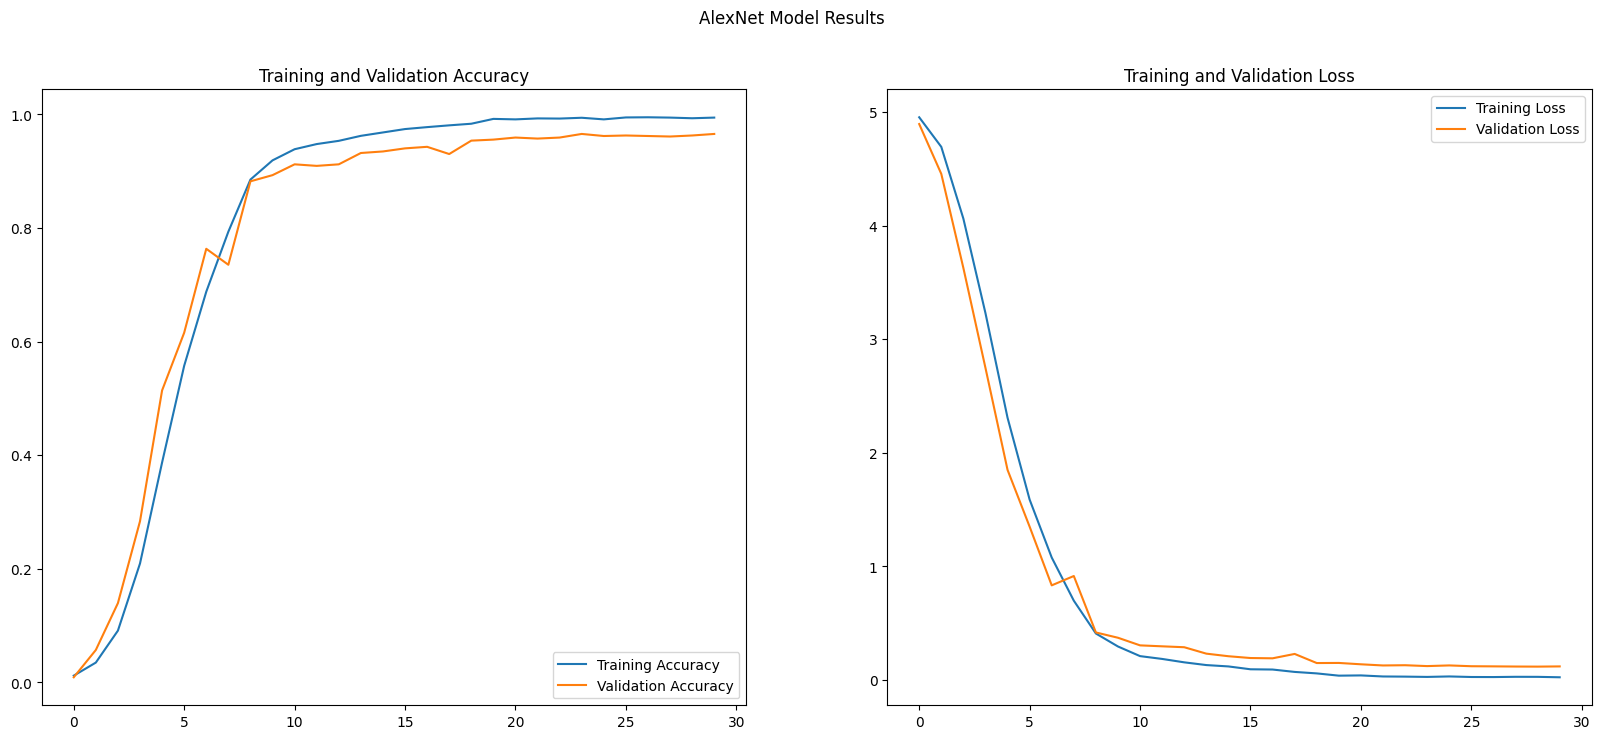

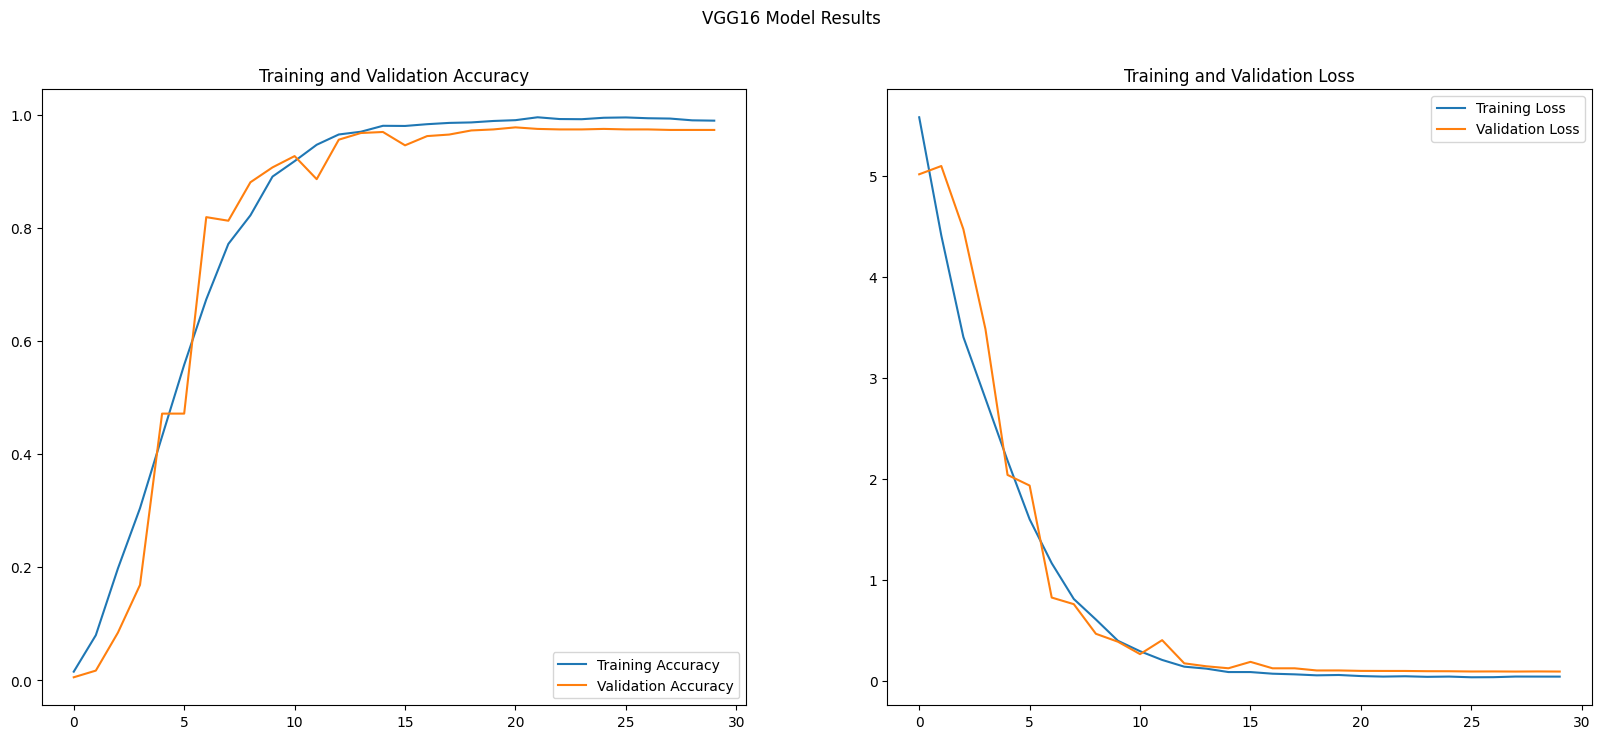

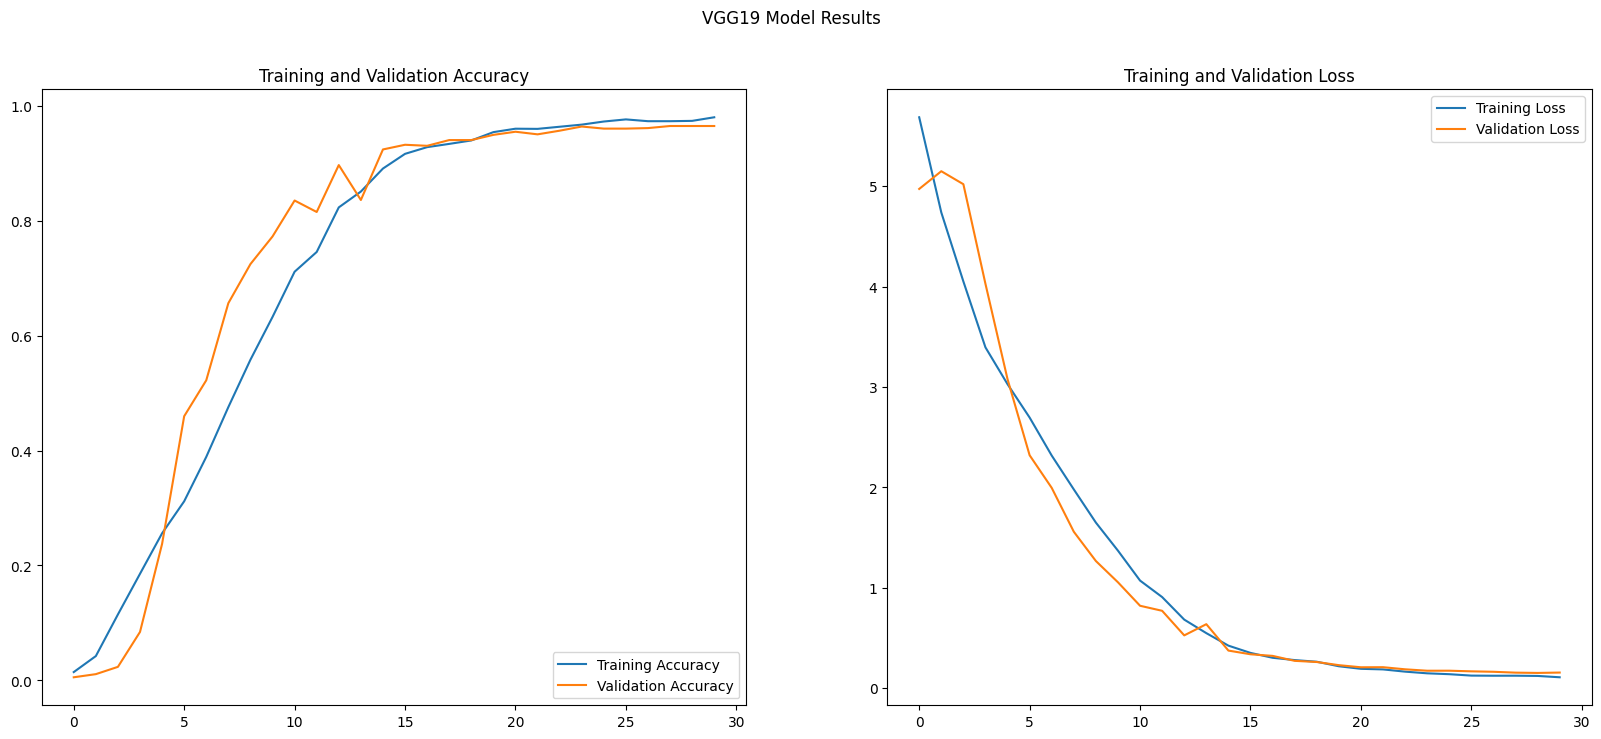

In [13]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

for name, history in model_histories.items():
    plot_model_performance(name, history)

In [14]:
model_results = {}

for name, model in models.items():
    model_results[name] = model[0].evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


27/27 [==============================] - 3s 33ms/step - loss: 0.0768 - accuracy: 0.9756
AlexNet Model Results:
Test accuracy: 97.56%
Test loss: 0.0768

27/27 [==============================] - 6s 128ms/step - loss: 0.0547 - accuracy: 0.9884
VGG16 Model Results:
Test accuracy: 98.84%
Test loss: 0.0547

27/27 [==============================] - 5s 68ms/step - loss: 0.1094 - accuracy: 0.9791
VGG19 Model Results:
Test accuracy: 97.91%
Test loss: 0.1094



Saving models and their training histories

In [15]:
for name, model in models.items():
    model[0].save(f'Saved Models/DorsalVein/{name}-{model_results[name][1]*100:.2f}%.keras')
    print(f'Saved {name} Model')

del history.history['lr']

for name, model in model_histories.items():
    with open(f'Model Histories/DorsalVein/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


## Loading trained model

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load train and val datasets
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Augmented Dorsal Vein/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 5516 files belonging to 138 classes.
Using 4413 files for training.
Using 1103 files for validation.

Total number of samples in train_dataset: 3520 (110 batches of 32)
Total number of samples in validation_dataset: 1120 (35 batches of 32)
Total number of samples in test_dataset: 864 (27 batches of 32)


In [3]:
alexnet_model = keras.models.load_model('Saved Models/DorsalVein/AlexNet-97.56%.keras')
vgg16_model = keras.models.load_model('Saved Models/DorsalVein/VGG16-98.84%.keras')
vgg19_model = keras.models.load_model('Saved Models/DorsalVein/VGG19-97.91%.keras')

In [4]:
def decision_level_fusion_paper(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

paper_fusion_accuracy = decision_level_fusion_paper(test_dataset)
print(f"Accuracy: {paper_fusion_accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 27/27 [04:38<00:00, 10.32s/batch]

Accuracy: 98.95%


In [5]:
def decision_level_fusion_improved(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

improved_fusion_accuracy = decision_level_fusion_improved(test_dataset)
print(f"Test Accuracy: {improved_fusion_accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 27/27 [02:30<00:00,  5.59s/batch]

Test Accuracy: 99.19%


In [6]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(paper_fusion_accuracy)
y.append(improved_fusion_accuracy)

Text(0.5, 1.0, 'DorsalVein Results Comparison')

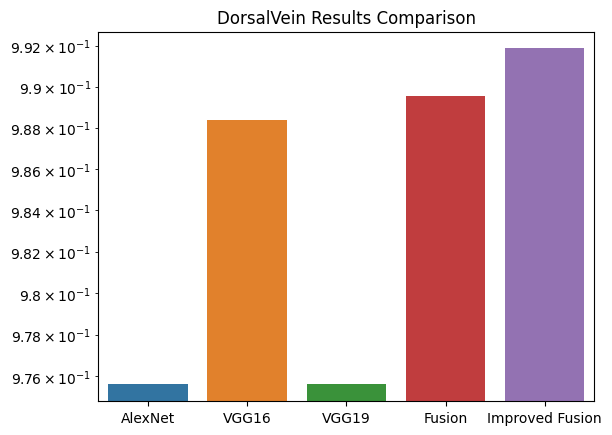

In [11]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion', 'Improved Fusion'])
plt.title('DorsalVein Results Comparison')

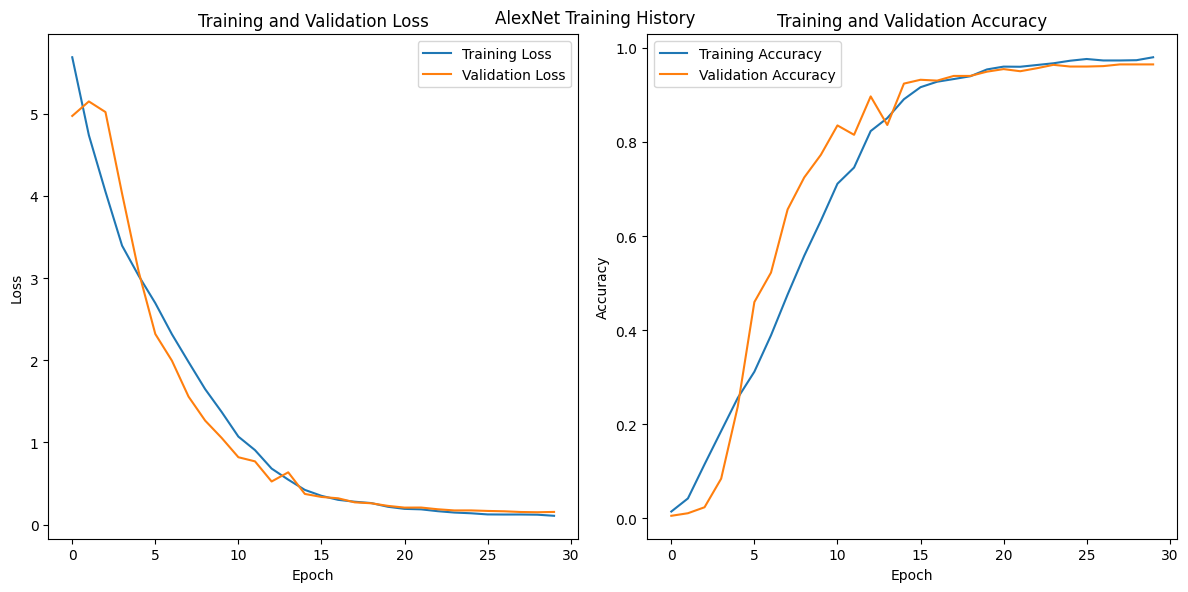

In [8]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/AlexNet-97.56%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


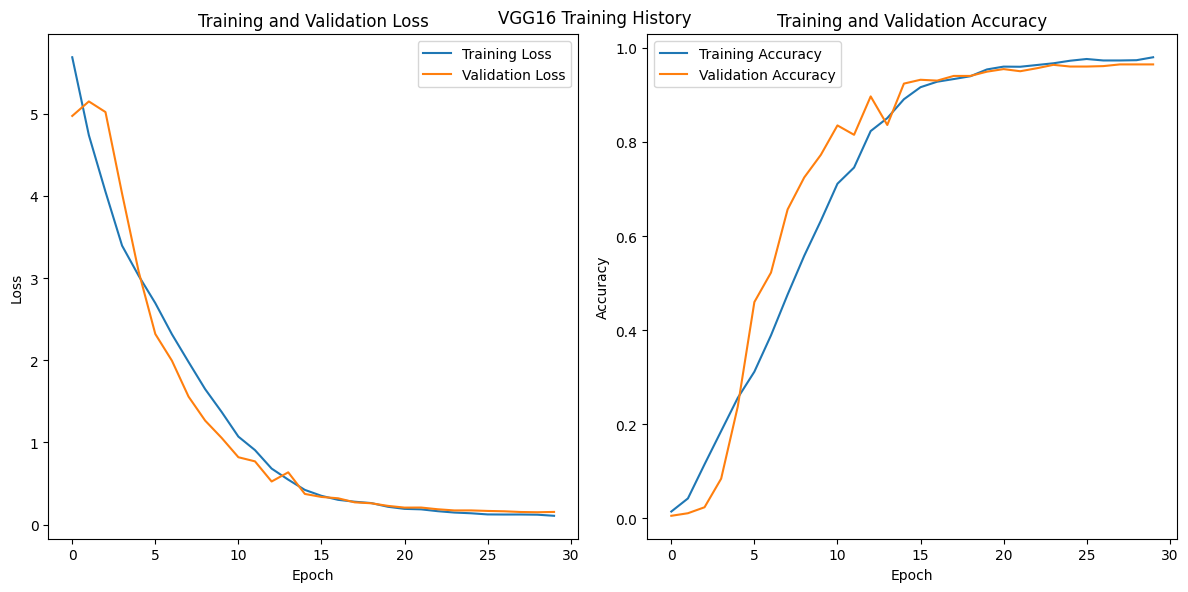

In [9]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/VGG16-98.84%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


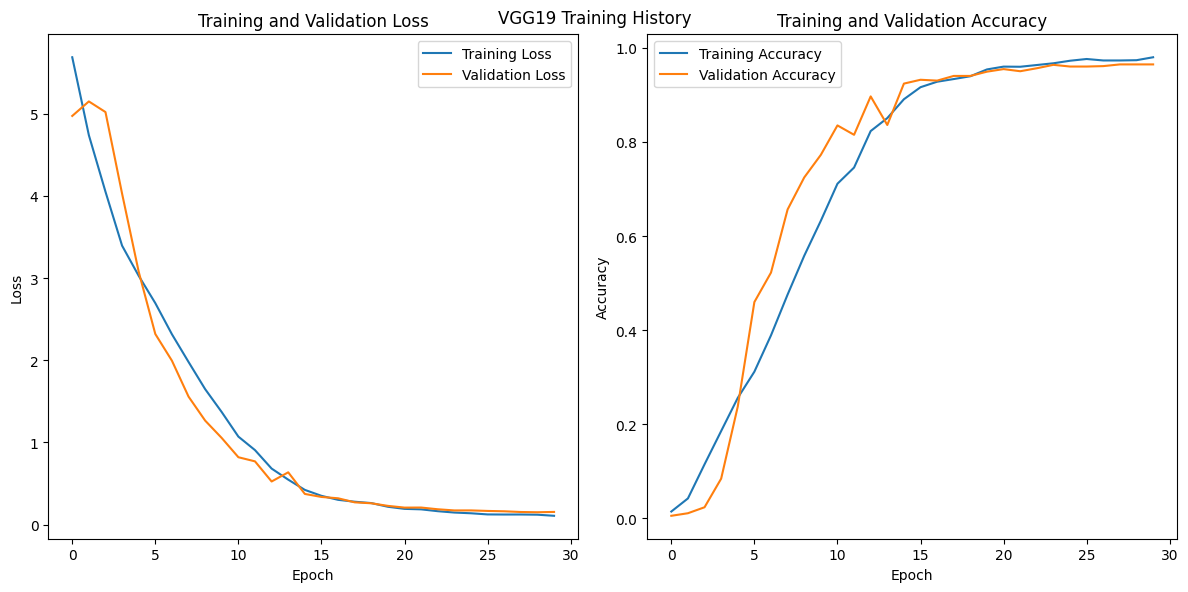

In [10]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/VGG19-97.91%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
